In [3]:
import numpy as np 
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta

from icenet.plotting.utils import get_obs_da, get_forecast_ds, filter_ds_by_obs, get_seas_forecast_da, get_seas_forecast_init_dates
from icenet.data.sic.mask import Masks
from icenet.plotting.forecast import (compute_metrics,
                                      compute_binary_accuracy,
                                      compute_sea_ice_extent_error,
                                      compute_metrics_leadtime_avg,
                                      plot_metrics,
                                      plot_binary_accuracy,
                                      plot_sea_ice_extent_error,
                                      plot_metrics_leadtime_avg)

from IPython.display import Image

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

2023-03-13 17:07:04.857521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:07:05.070455: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
import os
os.chdir("/data/hpcdata/users/rychan/icenet/")

In [5]:
os.listdir("./data/")

['osisaf',
 'era5',
 'masks',
 'mars.hres',
 'cmip6.MRI-ESM2-0.r1i1p1f1',
 'oras5',
 'mars.seas']

In [6]:
forecast_file = "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc"
fc_ds = xr.open_dataset(forecast_file)
fc_ds

<xarray.Dataset>
Dimensions:                 (time: 120, yc: 432, xc: 432, leadtime: 93)
Coordinates:
  * time                    (time) datetime64[ns] 2016-01-01 ... 2020-12-15
  * leadtime                (leadtime) int64 1 2 3 4 5 6 7 ... 88 89 90 91 92 93
    forecast_date           (time, leadtime) datetime64[ns] ...
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    sic_mean                (time, yc, xc, leadtime) float32 ...
    sic_stddev              (time, yc, xc, leadtime) float32 ...
Attributes: (12/36)
    Conventions:               CF-1.6 ACDD-1.3
    comments:                  
    creator_email:             jambyr@bas.ac.uk
    creator_institution:       British Antarctic Survey
    creator_name:              James Byrne
    creator_url:               www.bas.ac.uk
    ...                        ...
    summary:                   \n            This is an output of sea ice con...
    time_coverage_start:       
    time_coverage_end:         
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    title:                     Sea Ice Concentration Prediction

In [7]:
fc_ds.time.values

array(['2016-01-01T00:00:00.000000000', '2016-01-15T00:00:00.000000000',
       '2016-02-01T00:00:00.000000000', '2016-02-15T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-03-15T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-04-15T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-05-15T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-06-15T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-07-15T00:00:00.000000000',
       '2016-08-01T00:00:00.000000000', '2016-08-15T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-09-15T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-10-15T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-11-15T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2016-12-15T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-01-15T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-02-15

In [8]:
date_of_interest = pd.Timestamp("2020-03-01")

In [9]:
masks = Masks(north=True)
fc = get_forecast_ds(forecast_file=forecast_file,
                     forecast_date=date_of_interest)
obs = get_obs_da(hemisphere="north",
                start_date=pd.to_datetime(date_of_interest) + timedelta(days=1),
                end_date=pd.to_datetime(date_of_interest) + timedelta(days=int(fc.leadtime.max())))
fc = filter_ds_by_obs(fc, obs, date_of_interest)

INFO:root:Got files: ['./data/osisaf/north/siconca/2020.nc']
INFO:root:Starting index will be 0 for 2020-03-02 00:00:00 - 2020-06-02 00:00:00


In [12]:
fc_binacc = compute_binary_accuracy(masks=masks,
                                    fc_da=fc,
                                    obs_da=obs,
                                    threshold=0.15)
fc_binacc

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [13]:
fc_binacc.values

array([98.98083494, 98.79067003, 98.41034022, 98.22017531, 98.31525776,
       98.0300104 , 97.83984549, 97.22180954, 96.88902095, 96.55623236,
       96.36606745, 95.79557272, 95.65294904, 95.36770168, 95.32016045,
       95.41524291, 95.51032536, 95.03491309, 94.65458327, 94.60704204,
       94.60704204, 94.32179468, 94.36933591, 93.98900609, 93.6562175 ,
       93.6562175 , 93.6562175 , 93.75129996, 93.84638241, 93.6562175 ,
       93.49212077, 93.58835559, 93.25153374, 92.9628293 , 92.48165524,
       92.48165524, 92.86659449, 93.01094671, 92.9147119 , 92.67412486,
       92.57789005, 92.67412486, 92.81847708, 93.34776856, 93.6845904 ,
       93.92517743, 93.73270781, 94.02141225, 93.97329484, 93.58835559,
       93.54023818, 93.73270781, 93.54023818, 93.58835559, 93.73270781,
       93.73270781, 93.58835559, 93.78082521, 93.92517743, 93.97329484,
       93.73233259, 93.47239822, 93.36842447, 93.62835884, 93.88829321,
       94.04425383, 94.14822757, 93.99226695, 93.94028008, 93.42

In [14]:
if not os.path.exists("plot/"):
    os.makedirs("plot/")

INFO:root:Saving to plot/binacc.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 None)

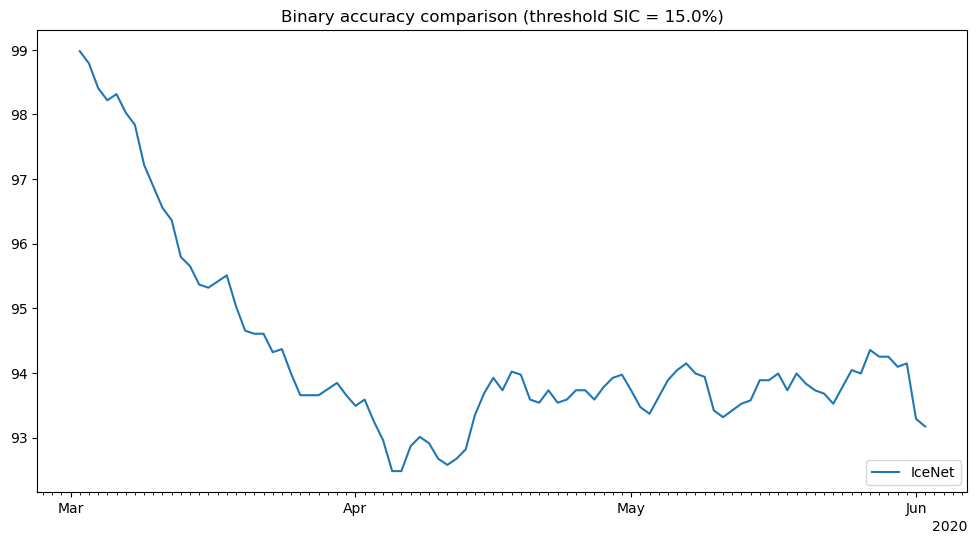

In [15]:
plot_binary_accuracy(masks=masks,
                     fc_da=fc,
                     obs_da=obs,
                     cmp_da=None,
                     output_path="plot/binacc.png")

In [16]:
cmp = get_seas_forecast_da(hemisphere="north",
                           date=date_of_interest,
                           bias_correct=True)
cmp = cmp.assign_coords(dict(xc=cmp.xc / 1e3, yc=cmp.yc / 1e3))
cmp = cmp.isel(time=slice(1, None))

INFO:root:Got files: ['./data/osisaf/north/siconca/2010.nc', './data/osisaf/north/siconca/2011.nc', './data/osisaf/north/siconca/2012.nc', './data/osisaf/north/siconca/2013.nc', './data/osisaf/north/siconca/2014.nc', './data/osisaf/north/siconca/2015.nc', './data/osisaf/north/siconca/2016.nc', './data/osisaf/north/siconca/2017.nc', './data/osisaf/north/siconca/2018.nc', './data/osisaf/north/siconca/2019.nc', './data/osisaf/north/siconca/2020.nc', './data/osisaf/north/siconca/2021.nc', './data/osisaf/north/siconca/2022.nc', './data/osisaf/north/siconca/2023.nc']
INFO:root:Debiaser input ranges: obs 0.00 - 1.00, hist -0.00 - 1.00, fut 0.00 - 1.00
INFO:root:----- Running debiasing for variable: siconc -----
100%|██████████| 186624/186624 [00:12<00:00, 14427.24it/s]
INFO:root:Debiaser output range: -0.62 - 1.11
INFO:root:Returning SEAS data from ./data/mars.seas/north/siconca/20200301.nc from 2020-03-01 00:00:00


INFO:root:Saving to plot/binacc_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

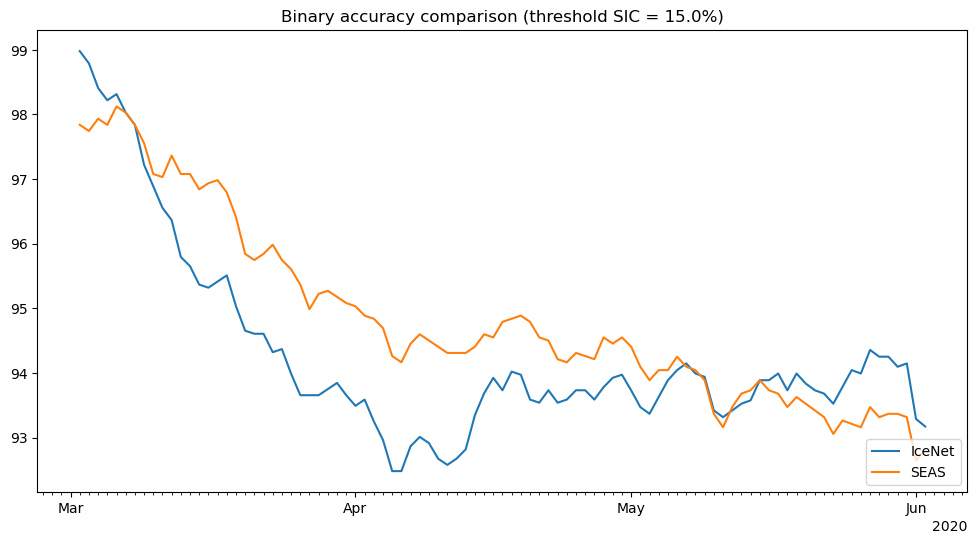

In [17]:
plot_binary_accuracy(masks=masks,
                     fc_da=fc,
                     obs_da=obs,
                     cmp_da=cmp,
                     output_path="plot/binacc_comp.png")

In [18]:
fc_sie = compute_sea_ice_extent_error(masks=masks,
                                      fc_da=fc,
                                      obs_da=obs,
                                      grid_area_size=25,
                                      threshold=0.15)
fc_sie

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [19]:
fc_sie.values

array([  76875,   44375,   96250,  135000,  178125,  163750,  150625,
        146875,  105625,  200000,  217500,  243750,  248125,  239375,
        275625,  264375,  281875,  253125,  323750,  458125,  483125,
        520625,  588750,  705000,  717500,  820000,  813750,  770000,
        751250,  802500,  820625,  815625,  930625, 1005000, 1063125,
       1028750,  994375, 1038750,  999375,  995000, 1026875,  950625,
        947500,  917500,  881250,  851875,  921875,  841250,  801875,
        794375,  761250,  720000,  727500,  753750,  747500,  698125,
        695000,  615625,  557500,  541875,  521875,  520000,  540625,
        543125,  540625,  556250,  558125,  595625,  608125,  676250,
        688125,  685625,  740000,  758750,  757500,  785000,  800000,
        844375,  804375,  770625,  834375,  818750,  830625,  798125,
        741875,  686250,  668750,  642500,  685000,  674375,  718750,
        721250,  731875])

INFO:root:Saving to plot/SIE_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

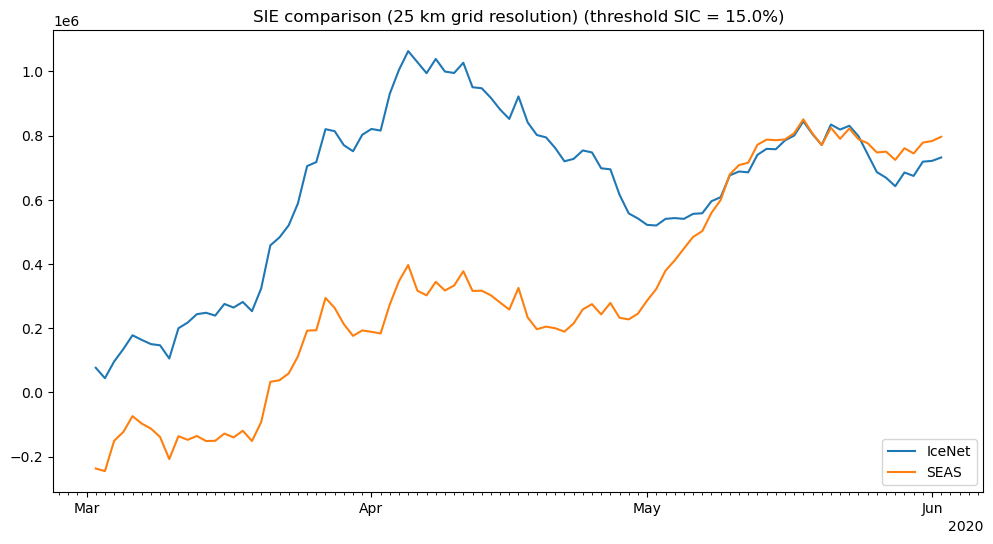

In [20]:
plot_sea_ice_extent_error(masks=masks,
                          fc_da=fc,
                          obs_da=obs,
                          cmp_da=cmp,
                          output_path="plot/SIE_comp.png")

In [21]:
fc_mse = compute_metrics(metrics=["MSE"],
                         masks=masks,
                         fc_da=fc,
                         obs_da=obs)
fc_mse

{'MSE': <xarray.DataArray (time: 93)>
 dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02}

In [22]:
fc_mse["MSE"].values

array([ 17.13769827,  25.47456153,  35.53338732,  43.18136778,
        39.86358442,  44.09824818,  57.55528042,  75.29843531,
       107.07803874, 124.2947431 , 124.06586386, 140.17746759,
       133.14043123, 137.88519184, 145.24297175, 145.96910252,
       146.48547963, 169.55472933, 186.31858115, 185.96634374,
       187.71557842, 198.97399303, 197.12847756, 214.3392683 ,
       221.24170006, 231.0664969 , 228.27555968, 226.61731117,
       233.07265885, 241.24277498, 251.47592501, 255.1905393 ,
       260.7064084 , 260.10935576, 270.15803133, 269.82870519,
       257.43845104, 237.48355831, 243.5591056 , 262.26993232,
       273.85084064, 276.65096893, 275.7159888 , 251.71312558,
       230.11248063, 218.78079019, 225.84145027, 211.85207229,
       215.02184579, 227.23700015, 233.46048888, 231.50557438,
       233.62792248, 236.88978989, 237.38442098, 234.1919153 ,
       227.62406243, 214.44678946, 205.69518032, 197.8897441 ,
       207.83208446, 220.20599674, 221.97901196, 209.96

INFO:root:Saving to plot/MSE_comp.png


({'MSE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02},
 {'MSE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
    * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02})

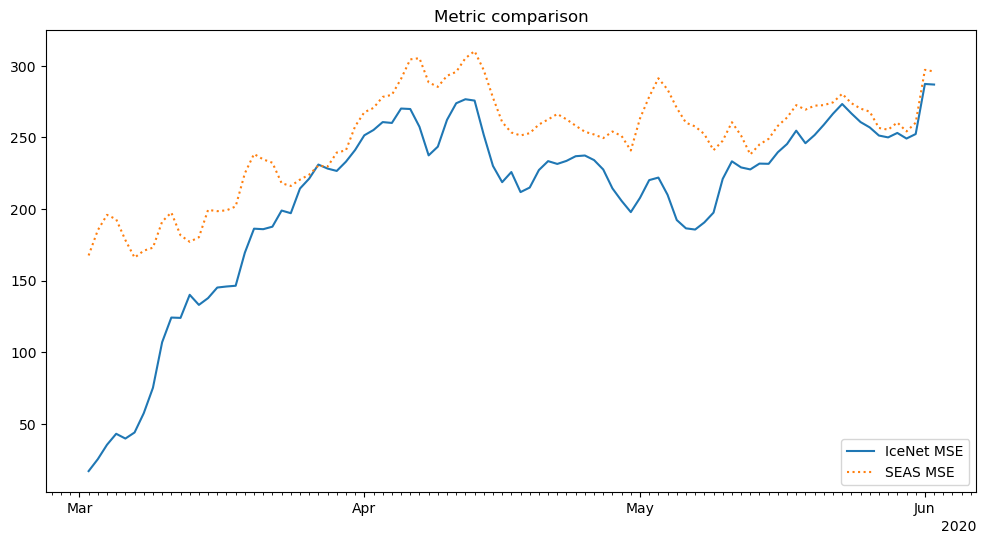

In [23]:
plot_metrics(metrics=["MSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs, 
             cmp_da=cmp,
             output_path="plot/MSE_comp.png")

INFO:root:Saving to plot/MAE_RMSE_comp.png


({'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02},
 {'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
    * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=

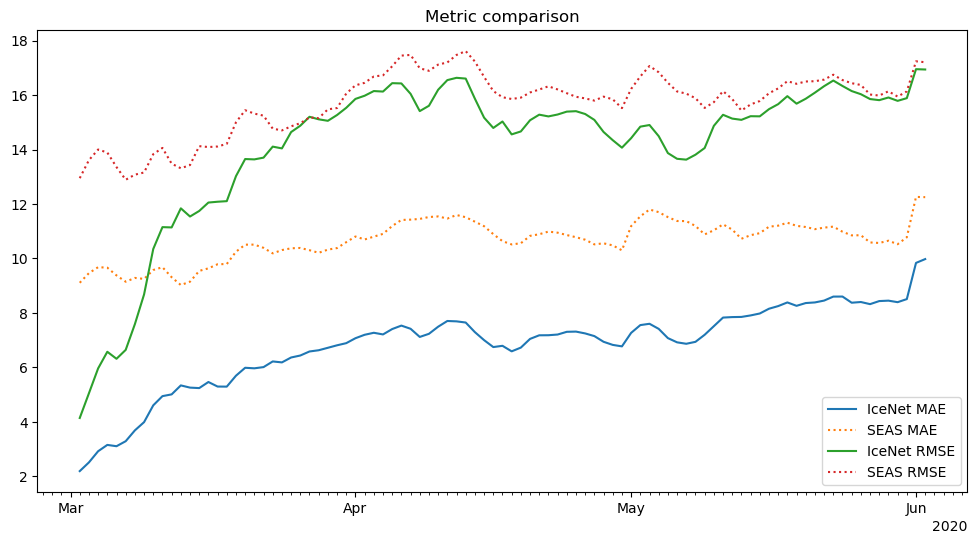

In [25]:
plot_metrics(metrics=["MAE", "RMSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs,
             cmp_da=cmp,
             output_path="plot/MAE_RMSE_comp.png")

In [43]:
if not os.path.exists("metrics/"):
    os.makedirs("metrics/")

In [8]:
binacc_leadtime_avg_df = compute_metrics_leadtime_avg(metric="binacc",
                                                      masks=masks,
                                                      hemisphere="north",
                                                      forecast_file=forecast_file,
                                                      emcwf=False,
                                                      data_path="metrics/binacc_leadtime_avg.csv",
                                                      threshold=0.15)

INFO:root:Computing binacc for 120 forecasts
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-01-02 00:00:00 - 2016-04-03 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-01-16 00:00:00 - 2016-04-17 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-02-02 00:00:00 - 2016-05-04 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-02-16 00:00:00 - 2016-05-18 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-03-02 00:00:00 - 2016-06-02 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 2016-03-16 00:00:00 - 2016-06-16 00:00:00
INFO:root:Got files: ['./data/osisaf/north/siconca/2016.nc']
INFO:root:Starting index will be 0 for 201

In [9]:
binacc_leadtime_avg_df

,date,dayofyear,month,target_date,target_dayofyear,target_month,leadtime,binacc,forecast_name
0,2016-01-01,1,1,2016-01-02,2,1,1,98.913668,IceNet
1,2016-01-01,1,1,2016-01-03,3,1,2,98.526341,IceNet
2,2016-01-01,1,1,2016-01-04,4,1,3,98.090598,IceNet
3,2016-01-01,1,1,2016-01-05,5,1,4,97.800103,IceNet
4,2016-01-01,1,1,2016-01-06,6,1,5,97.606439,IceNet
...,...,...,...,...,...,...,...,...,...
11155,2020-12-15,349,12,2021-03-14,73,3,89,93.703759,IceNet
11156,2020-12-15,349,12,2021-03-15,74,3,90,93.846382,IceNet
11157,2020-12-15,349,12,2021-03-16,75,3,91,93.893924,IceNet
11158,2020-12-15,349,12,2021-03-17,76,3,92,94.321795,IceNet


INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for binacc metric
/data/hpcdata/users/rychan/icenet/icenet_fork/icenet/plotting/forecast.py:759: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fc_avg_metric = fc_metric_df.groupby("leadtime").mean().\
INFO:root:Saving to plot/binacc_leadtime_avg_all.png


(       Unnamed: 0       date  dayofyear  month target_date  target_dayofyear  \
 0               0 2016-01-01          1      1  2016-01-02                 2   
 1               1 2016-01-01          1      1  2016-01-03                 3   
 2               2 2016-01-01          1      1  2016-01-04                 4   
 3               3 2016-01-01          1      1  2016-01-05                 5   
 4               4 2016-01-01          1      1  2016-01-06                 6   
 ...           ...        ...        ...    ...         ...               ...   
 11155          88 2020-12-15        349     12  2021-03-14                73   
 11156          89 2020-12-15        349     12  2021-03-15                74   
 11157          90 2020-12-15        349     12  2021-03-16                75   
 11158          91 2020-12-15        349     12  2021-03-17                76   
 11159          92 2020-12-15        349     12  2021-03-18                77   
 
        target_month  lead

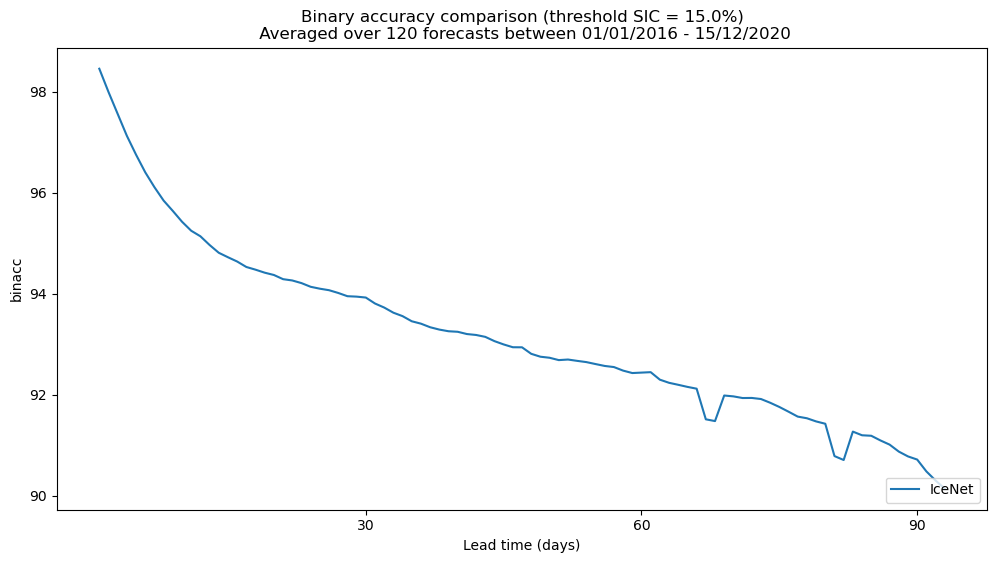

In [27]:
plot_metrics_leadtime_avg(metric="binacc",
                          masks=masks,
                          hemisphere="north",
                          forecast_file=forecast_file,
                          emcwf=False,
                          output_path="plot/binacc_leadtime_avg_all.png",
                          average_over="all",
                          data_path="metrics/binacc_leadtime_avg.csv")

In [11]:
!icenet_plot_leadtime_avg -h

2023-03-13 15:30:39.266905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 15:30:39.439651: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_leadtime_avg [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b]
                                [-e] [-m METRIC] [-dp DATA_PATH]
                                [-ao {all,month,day}] [-td]
                                {north,south} forecast_file

positional arguments:
  {north,south}
  forecast_file

optional arguments:
  -h, -

In [28]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg.csv" \
    -ao "month"

2023-03-13 17:15:50.044427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:15:50.227363: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/leadtime_averaged_init_month_binacc.png


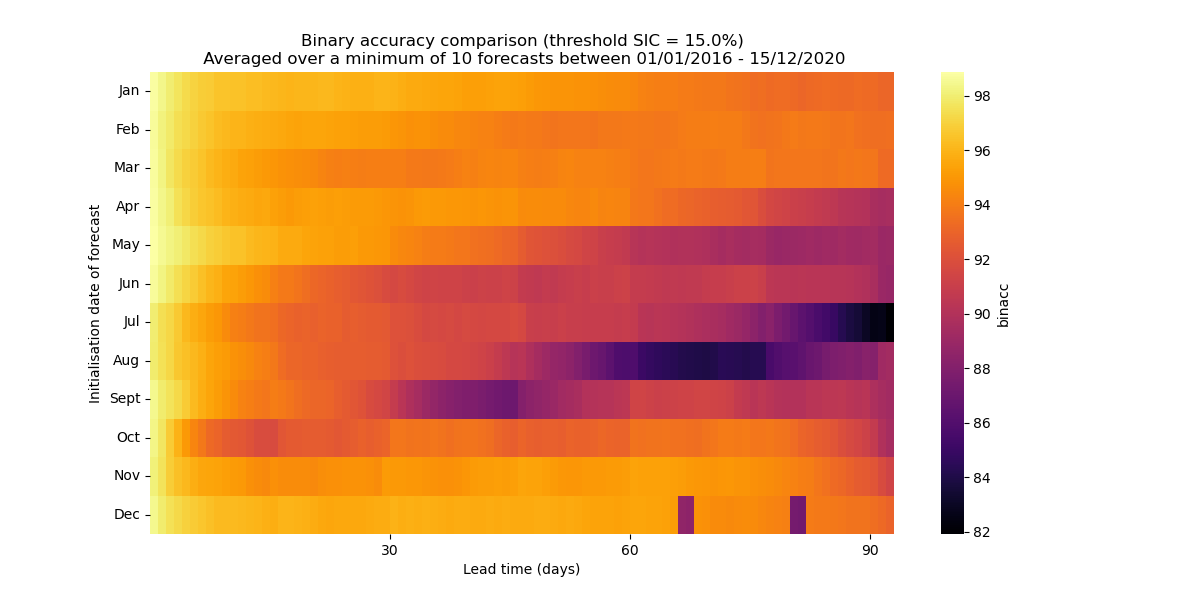

In [29]:
Image("plot/leadtime_averaged_init_month_binacc.png")

In [30]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg.csv" \
    -ao "day"

2023-03-13 17:16:24.846472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:16:25.050503: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/leadtime_averaged_init_day_binacc.png


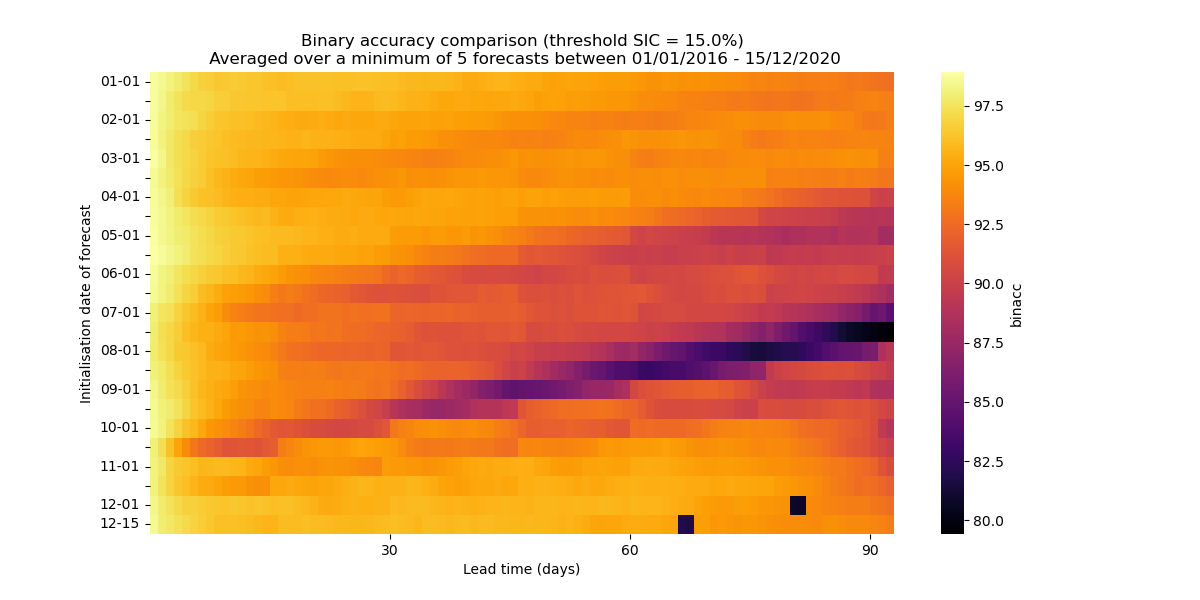

In [31]:
Image("plot/leadtime_averaged_init_day_binacc.png")

In [41]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg.csv" \
    -ao "day" \
    -td

2023-03-13 17:19:36.573586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:19:36.728793: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/leadtime_averaged_target_day_binacc.png


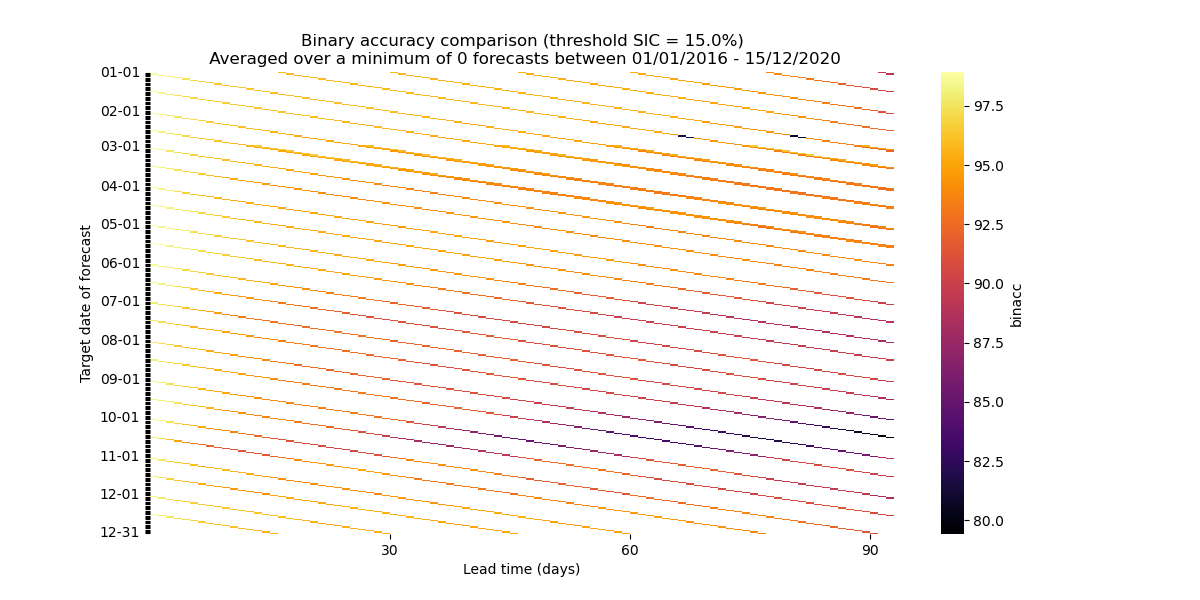

In [42]:
Image("plot/leadtime_averaged_target_day_binacc.png")

In [43]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -o "plot/binacc_leadtime_avg_all_comp.png" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg_comp.csv" \
    -ao "all" \
    -e

2023-03-13 17:19:54.968696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:19:55.127849: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for binacc metric
/data/hpcdata/users/rychan/icenet/icenet_fork/icenet/plotting/forecast.py:759: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, num

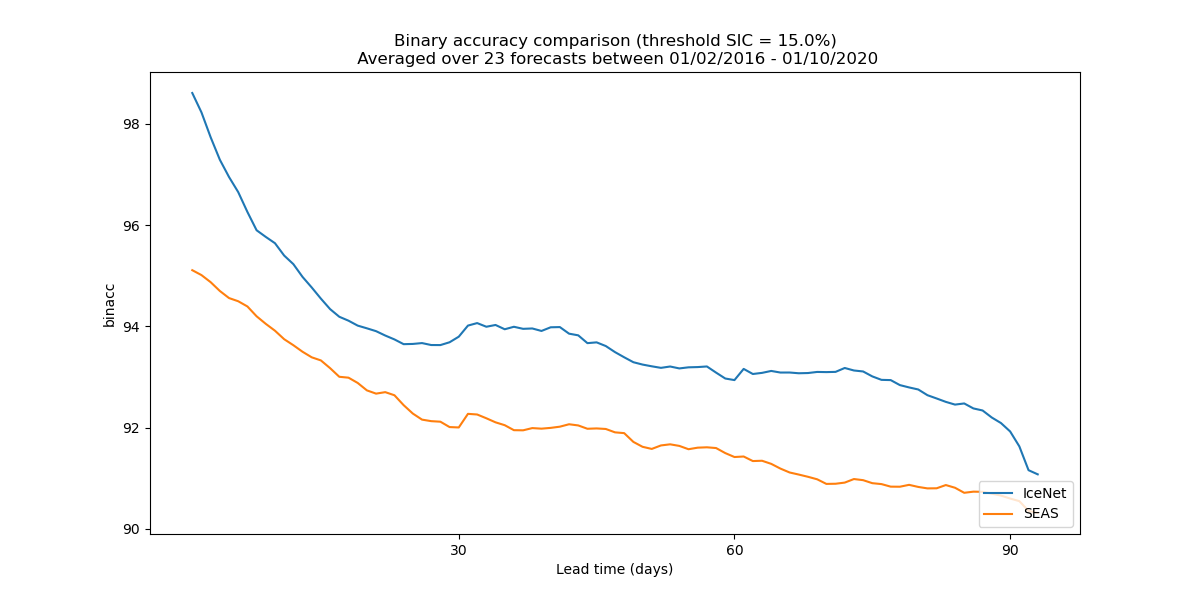

In [44]:
Image("plot/binacc_leadtime_avg_all_comp.png")

In [34]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg_comp.csv" \
    -ao "month" \
    -e

2023-03-13 17:18:41.703256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:18:41.912263: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/leadtime_averaged_init_month_binacc_comp.png


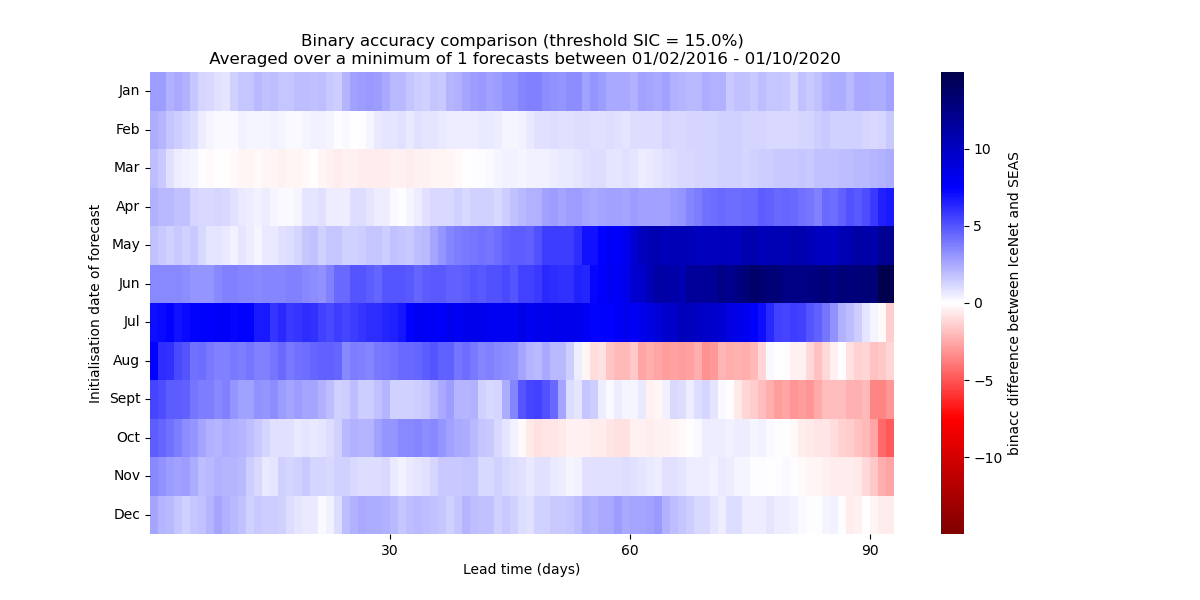

In [45]:
Image("plot/leadtime_averaged_init_month_binacc_comp.png")

In [35]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "binacc" \
    -dp "metrics/binacc_leadtime_avg_comp.csv" \
    -ao "day" \
    -e

2023-03-13 17:18:47.481423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:18:47.651468: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/binacc_leadtime_avg_day_comp.png


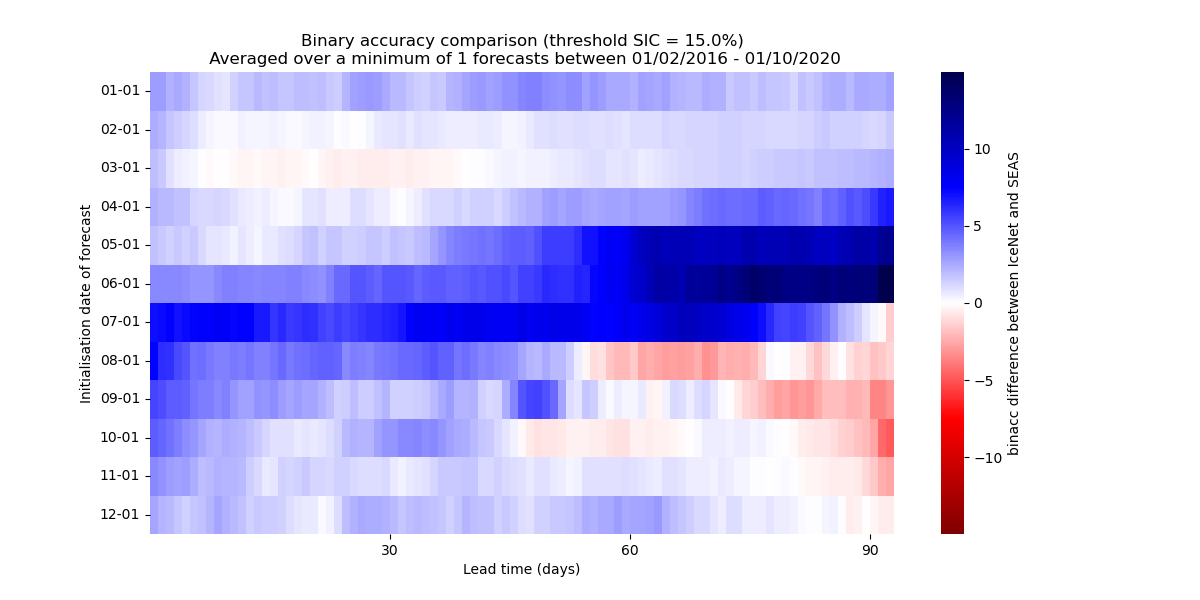

In [46]:
Image("plot/binacc_leadtime_avg_day_comp.png")

In [36]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "SIE" \
    -dp "metrics/SIE_leadtime_avg_comp.csv" \
    -ao "all" \
    -e

2023-03-13 17:18:57.210695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:18:57.407857: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/SIE_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for SIE metric
/data/hpcdata/users/rychan/icenet/icenet_fork/icenet/plotting/forecast.py:759: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_o

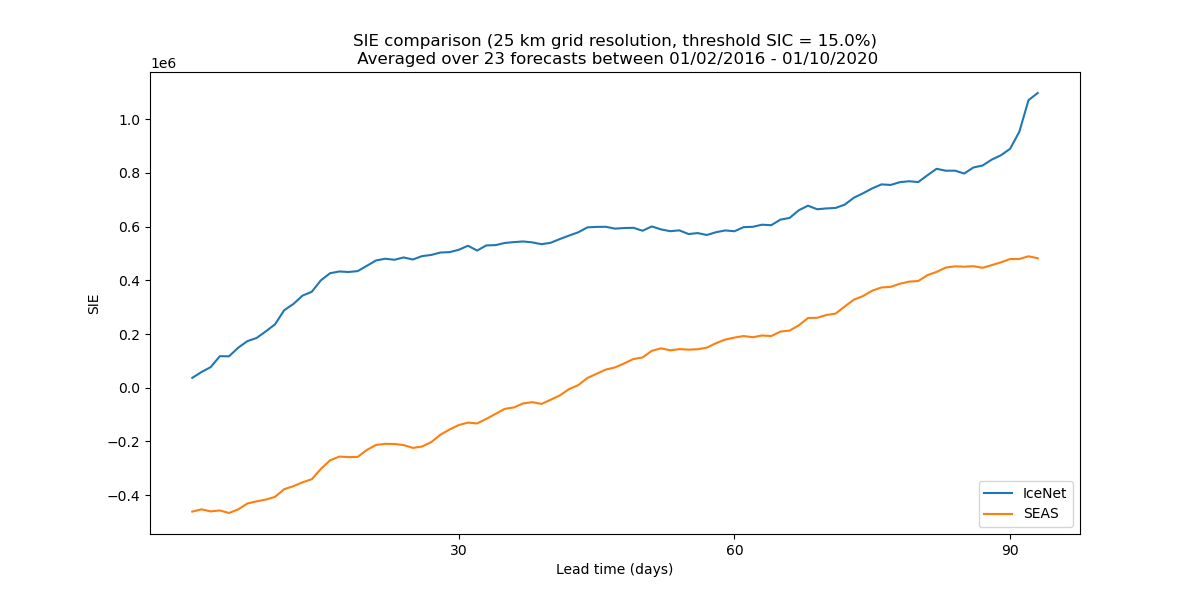

In [47]:
Image("plot/leadtime_averaged_init_all_SIE_comp.png")

In [37]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "MAE" \
    -dp "metrics/MAE_leadtime_avg.csv" \
    -ao "day"

2023-03-13 17:19:06.389636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:19:06.567911: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/MAE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for MAE metric
INFO:root:Saving to plot/leadtime_averaged_init_day_MAE.png


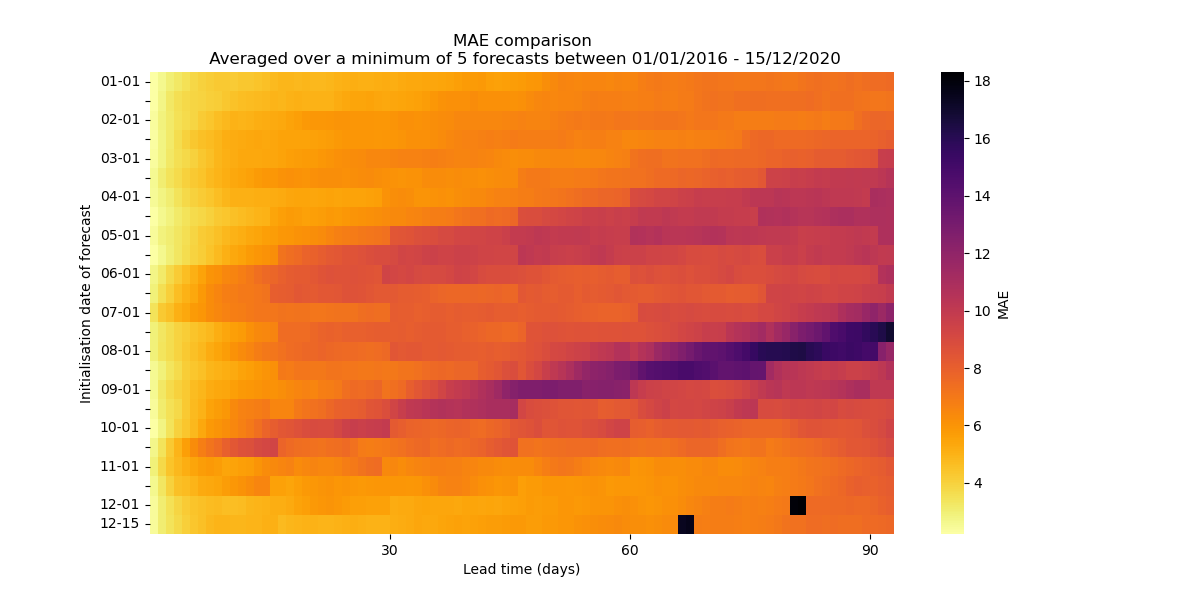

In [48]:
Image("plot/leadtime_averaged_init_day_MAE.png")

In [39]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "MAE" \
    -dp "metrics/MAE_leadtime_avg.csv" \
    -ao "day" \
    -td

2023-03-13 17:19:15.146369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:19:15.301577: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/MAE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for MAE metric
INFO:root:Saving to plot/leadtime_averaged_target_day_MAE.png


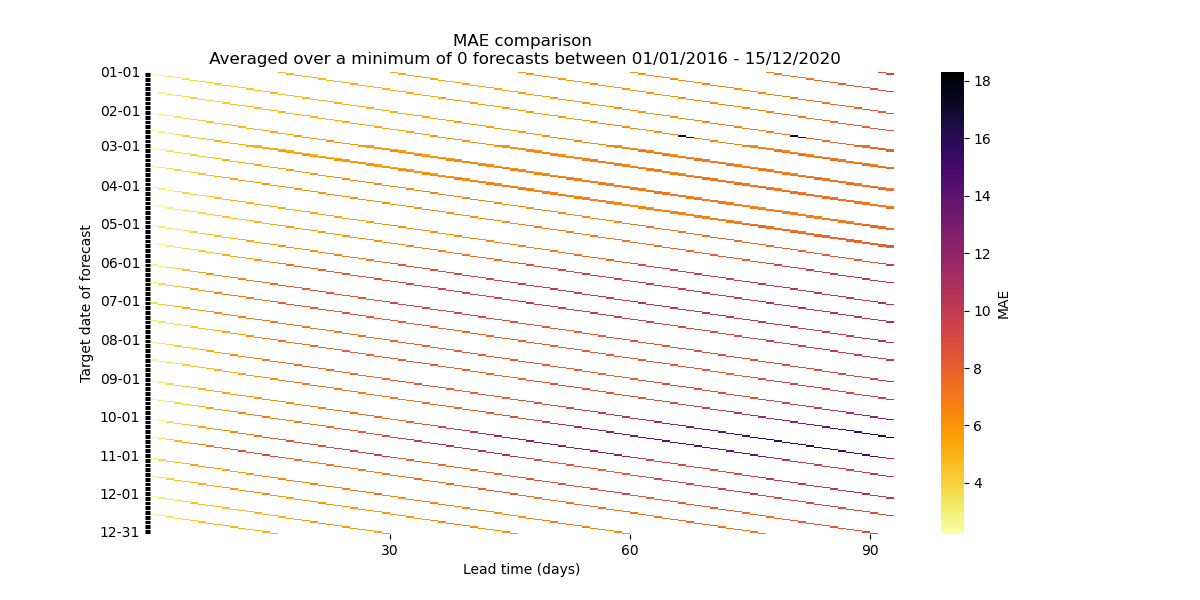

In [49]:
Image("plot/leadtime_averaged_target_day_MAE.png")

In [50]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "MAE" \
    -dp "metrics/MAE_leadtime_avg_comp.csv" \
    -ao "day" \
    -e

2023-03-13 17:21:50.631214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:21:50.789610: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/MAE_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for MAE metric
INFO:root:Saving to plot/leadtime_averaged_init_day_MAE_comp.png


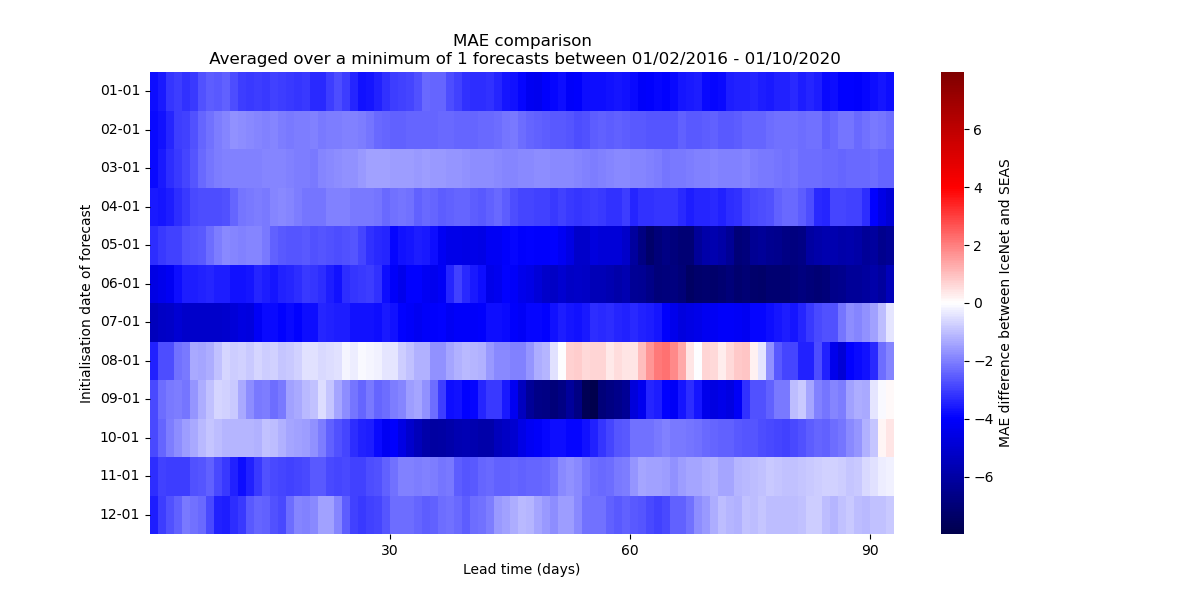

In [51]:
Image("plot/leadtime_averaged_init_day_MAE_comp.png")